## Note
The paramters in this sample code are similar to  our main training code but we test this code on limited number of data for the sake of speed


## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data directory 

In [ ]:
import glob
import os
import numpy as np
from tqdm import tqdm

folder_npy = '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

In [ ]:
# Splite data for Health (h) class
h_path = file_paths[55:110]
print(h_path)

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0001_288_270_368_normal001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0002_334_334_370_normal002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0003_338_344_393_normal003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0004_256_258_340_normal004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0005_286_252_310_normal005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0006_288_237_321_normal006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0007_284_372_368_normal007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0008_278_266_337_normal008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0009_290_292_365_normal009.npy', '/content/drive/MyDrive/googledrive_

## BCDU-net

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import core
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import ConvLSTM2D
from keras.optimizers import Adam
    
def BCDU_net_D3(input_size = (128,128,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal')(merge6)
            
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 32))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 32))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 16, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    return model

In [ ]:
model = BCDU_net_D3(input_size = (128,128,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Resizing the slices for BCDUNet model

In [ ]:
from skimage.transform import resize

In [ ]:
output = np.zeros((1,128,128))
for i in tqdm(h_path):
    data = np.load(i)
    data = resize(data, (data.shape[0],128, 128),anti_aliasing=True)
    output = np.append(output,data,axis=0)
output = output[1:]

100%|██████████| 55/55 [04:44<00:00,  5.18s/it]


### Adding noise

In [ ]:
!pip install noise

     |████████████████████████████████| 133kB 4.1MB/s 
  Created wheel for noise: filename=noise-1.2.2-cp37-cp37m-linux_x86_64.whl size=64278 sha256=878756e279a1189805a92d400f2837bf7813a1cb9e5880cc06019706def64aa8
  Stored in directory: /root/.cache/pip/wheels/fd/a3/c1/d36defe6e9f074b25dc0f018eb9f8fdd675a7ef87071ce3821
Successfully built noise


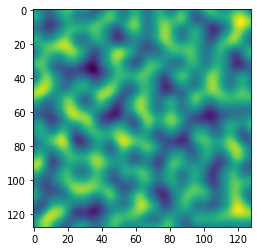

In [ ]:
import noise
import cv2

def add_noise(input_array):
    shape = (128,128)
    scale = np.random.randint(10,30)
    # scale = 12
    # scale = 30
    octaves = 10
    persistence = 0.01*np.random.randint(-50,50)
    # persistence = 0.1
    lacunarity = 2.0
    seed = np.random.randint(0,1000)
    # seed = 33
    world = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            world[i][j] = noise.pnoise2(i/scale, 
                                        j/scale, 
                                        octaves=octaves, 
                                        persistence=persistence, 
                                        lacunarity=lacunarity, 
                                        repeatx=140, 
                                        repeaty=140, 
                                        base=seed)
    return cv2.addWeighted(input_array, 1, world, 1, 0)  

import matplotlib.pyplot as plt
a  = np.zeros((128,128))
plt.imshow(add_noise(a)) 

In [ ]:
from tqdm import tqdm
noisy_output = np.zeros(output.shape)
for i in tqdm(range(output.shape[0])):
    noisy_output[i] = add_noise(output[i,:,:])

100%|██████████| 16448/16448 [10:15<00:00, 26.73it/s]


In [ ]:
'''
Change half of data to original slices (without noise)
Suggestion: you can use random permutation to clean half of data
suggestyion: you can change the rate of being nosisy or clean! 
'''
noisy_output[int(noisy_output.shape[0]/5):] = output[int(noisy_output.shape[0]/5):]

In [ ]:
#target (without noise)
output = np.reshape(output,(output.shape[0],output.shape[1],output.shape[2],1))

#input (half noisy)
noisy_output = np.reshape(noisy_output,(noisy_output.shape[0],noisy_output.shape[1],noisy_output.shape[2],1))

### Training the model

In [ ]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy')

In [ ]:
history = model.fit(noisy_output, output,
            batch_size = 5,
            epochs = 3,
            shuffle=True,
            verbose=1)

Epoch 1/3
3290/3290 [==============================] - 894s 259ms/step - loss: 0.0858
Epoch 2/3
3290/3290 [==============================] - 849s 258ms/step - loss: 0.0745
Epoch 3/3
3290/3290 [==============================] - 847s 257ms/step - loss: 0.0742


In [ ]:
'''
However, you can save weights of your model for future use
'''
model.save_weights('/content/drive/My Drive/googledrive_segmentation/weight_half_lung_noisy_unet.hdf5')
model.load_weights('/content/drive/My Drive/googledrive_segmentation/weight_half_lung_noisy_unet.hdf5')

## 3D CNN model

In [ ]:
'''
Load all data to pass through BCDUNet to bold infections in out pipeline
Splite data for each class of COVID (c), Health or Control (h) and Pneumonia or CAP (p)

'''
c_path = file_paths[:55]
h_path = file_paths[55:110]
p_path = file_paths[110:165]
my_file_paths = c_path+h_path+p_path
print(my_file_paths)
print(len(my_file_paths))


['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

### Go Through BCDUNet all slices and pack them

In [ ]:
'''
Here, we:
1- Resize different size of slices (2D) -> in x,y axes
2- Predict all slices of a patient using BCDUNET
3- Do subtraction
1- Resize different size of CT images (3D) -> in z axis
'''
from skimage.transform import resize

from scipy import signal

dataset = np.zeros((len(my_file_paths),50,128,128))
counter = 0
for j in tqdm(my_file_paths):
    print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    c = CT_resized-out[:,:,:,0]
    dataset[counter] = resize(c,(50,128,128))
    counter +=1

  0%|          | 0/165 [00:00<?, ?it/s]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy


  1%|          | 1/165 [00:12<35:27, 12.97s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy


  1%|          | 2/165 [00:21<31:34, 11.62s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy


  2%|▏         | 3/165 [00:30<29:16, 10.84s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy


  2%|▏         | 4/165 [00:39<27:45, 10.35s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy


  3%|▎         | 5/165 [00:49<27:03, 10.14s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy


  4%|▎         | 6/165 [00:59<26:37, 10.05s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy


  4%|▍         | 7/165 [01:07<25:13,  9.58s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy


  5%|▍         | 8/165 [01:17<24:57,  9.54s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy


  5%|▌         | 9/165 [01:28<26:34, 10.22s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0010_276_286_294_CR_P010.npy


  6%|▌         | 10/165 [01:37<24:59,  9.67s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0011_270_297_333_CR_P011.npy


  7%|▋         | 11/165 [01:44<23:19,  9.09s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0012_330_346_375_CR_P012.npy


  7%|▋         | 12/165 [01:56<24:54,  9.77s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0013_342_334_354_CR_P013.npy


  8%|▊         | 13/165 [02:08<26:25, 10.43s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0014_284_269_310_CR_P014.npy


  8%|▊         | 14/165 [02:17<25:38, 10.19s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0015_296_276_347_CR_P015.npy


  9%|▉         | 15/165 [02:25<23:22,  9.35s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0016_332_325_368_CR_P016.npy


 10%|▉         | 16/165 [02:35<23:36,  9.51s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0017_236_250_309_CR_P017.npy


 10%|█         | 17/165 [02:41<21:20,  8.65s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0018_314_282_319_CR_P018.npy


 11%|█         | 18/165 [02:49<20:25,  8.34s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0019_300_272_359_CR_P019.npy


 12%|█▏        | 19/165 [02:57<20:00,  8.22s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0020_256_267_369_CR_P020.npy


 12%|█▏        | 20/165 [03:04<19:00,  7.87s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0021_326_326_374_CR_P021.npy


 13%|█▎        | 21/165 [03:15<20:56,  8.73s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0022_250_259_310_CR_P022.npy


 13%|█▎        | 22/165 [03:22<19:31,  8.19s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0023_294_318_372_CR_P023.npy


 14%|█▍        | 23/165 [03:33<21:34,  9.11s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0024_272_279_328_CR_P024.npy


 15%|█▍        | 24/165 [03:41<20:55,  8.90s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0025_318_301_317_CR_P025.npy


 15%|█▌        | 25/165 [03:49<19:53,  8.53s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0026_304_291_353_CR_P026.npy


 16%|█▌        | 26/165 [03:57<19:22,  8.36s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0027_268_347_369_CR_P027.npy


 16%|█▋        | 27/165 [04:06<19:33,  8.50s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0028_270_264_310_CR_P028.npy


 17%|█▋        | 28/165 [04:12<18:05,  7.92s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0029_262_313_343_CR_P029.npy


 18%|█▊        | 29/165 [04:19<17:15,  7.61s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0030_284_302_310_CR_P030.npy


 18%|█▊        | 30/165 [04:29<18:32,  8.24s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0031_306_317_372_CR_P031.npy


 19%|█▉        | 31/165 [04:39<19:56,  8.93s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0032_262_261_326_CR_P032.npy


 19%|█▉        | 32/165 [04:47<18:39,  8.42s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0033_298_323_370_CR_P033.npy


 20%|██        | 33/165 [04:55<18:43,  8.52s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0034_320_381_415_CR_P034.npy


 21%|██        | 34/165 [05:06<20:12,  9.26s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0035_338_300_351_CR_P035.npy


 21%|██        | 35/165 [05:16<20:04,  9.27s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0036_294_363_388_CR_P036.npy


 22%|██▏       | 36/165 [05:26<20:36,  9.59s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0037_244_306_319_CR_P037.npy


 22%|██▏       | 37/165 [05:33<18:38,  8.74s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0038_274_334_397_CR_P038.npy


 23%|██▎       | 38/165 [05:42<18:31,  8.75s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0039_346_325_384_CR_P039.npy


 24%|██▎       | 39/165 [05:53<19:52,  9.46s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0040_288_262_351_CR_P040.npy


 24%|██▍       | 40/165 [06:00<18:19,  8.80s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0041_292_308_371_CR_P041.npy


 25%|██▍       | 41/165 [06:11<19:36,  9.49s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0042_268_317_372_CR_P042.npy


 25%|██▌       | 42/165 [06:18<18:00,  8.79s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0043_296_314_390_CR_P043.npy


 26%|██▌       | 43/165 [06:27<17:57,  8.83s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0044_290_250_320_CR_P044.npy


 27%|██▋       | 44/165 [06:34<16:48,  8.33s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0045_328_282_374_CR_P045.npy


 27%|██▋       | 45/165 [06:44<17:12,  8.61s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0046_288_267_319_CR_P046.npy


 28%|██▊       | 46/165 [06:51<16:08,  8.14s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0047_320_234_288_CR_P047.npy


 28%|██▊       | 47/165 [06:58<15:47,  8.03s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0048_354_253_327_CR_P048.npy


 29%|██▉       | 48/165 [07:08<16:26,  8.43s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0049_282_254_310_CR_P049.npy


 30%|██▉       | 49/165 [07:16<16:08,  8.35s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0050_326_274_327_CR_P050.npy


 30%|███       | 50/165 [07:24<16:02,  8.37s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0051_316_273_375_CR_P051.npy


 31%|███       | 51/165 [07:33<15:55,  8.39s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0052_318_324_348_CR_P052.npy


 32%|███▏      | 52/165 [07:42<16:12,  8.60s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0053_318_299_336_CR_P053.npy


 32%|███▏      | 53/165 [07:50<16:03,  8.60s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0054_334_288_370_CR_P054.npy


 33%|███▎      | 54/165 [08:00<16:19,  8.82s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0055_304_303_372_CR_P055.npy


 33%|███▎      | 55/165 [08:08<16:04,  8.77s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0001_288_270_368_normal001.npy


 34%|███▍      | 56/165 [08:16<14:59,  8.26s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0002_334_334_370_normal002.npy


 35%|███▍      | 57/165 [08:26<15:52,  8.82s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0003_338_344_393_normal003.npy


 35%|███▌      | 58/165 [08:37<17:05,  9.58s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0004_256_258_340_normal004.npy


 36%|███▌      | 59/165 [08:46<16:48,  9.52s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0005_286_252_310_normal005.npy


 36%|███▋      | 60/165 [08:54<15:43,  8.98s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0006_288_237_321_normal006.npy


 37%|███▋      | 61/165 [09:02<14:46,  8.53s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0007_284_372_368_normal007.npy


 38%|███▊      | 62/165 [09:10<14:45,  8.60s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0008_278_266_337_normal008.npy


 38%|███▊      | 63/165 [09:17<13:34,  7.99s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0009_290_292_365_normal009.npy


 39%|███▉      | 64/165 [09:24<13:12,  7.84s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0010_304_368_384_normal010.npy


 39%|███▉      | 65/165 [09:34<14:05,  8.46s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0011_276_286_382_normal011.npy


 40%|████      | 66/165 [09:42<13:41,  8.30s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0012_320_363_377_normal012.npy


 41%|████      | 67/165 [09:53<14:56,  9.15s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0013_372_332_397_normal013.npy


 41%|████      | 68/165 [10:06<16:26, 10.17s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0014_280_284_312_normal014.npy


 42%|████▏     | 69/165 [10:14<15:09,  9.47s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0015_290_315_339_normal015.npy


 42%|████▏     | 70/165 [10:22<14:37,  9.24s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0016_248_272_298_normal016.npy


 43%|████▎     | 71/165 [10:29<13:03,  8.33s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0017_354_318_376_normal017.npy


 44%|████▎     | 72/165 [10:39<13:55,  8.98s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0018_272_258_352_normal018.npy


 44%|████▍     | 73/165 [10:46<12:46,  8.33s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0019_266_277_318_normal019.npy


 45%|████▍     | 74/165 [10:52<11:44,  7.74s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0020_274_245_310_normal020.npy


 45%|████▌     | 75/165 [10:59<10:56,  7.29s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0021_310_262_301_normal021.npy


 46%|████▌     | 76/165 [11:06<10:56,  7.38s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0022_298_334_372_normal022.npy


 47%|████▋     | 77/165 [11:15<11:25,  7.79s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0023_324_258_310_normal023.npy


 47%|████▋     | 78/165 [11:22<11:08,  7.69s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0024_334_276_302_normal024.npy


 48%|████▊     | 79/165 [11:30<11:00,  7.68s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0025_312_289_318_normal025.npy


 48%|████▊     | 80/165 [11:37<10:45,  7.59s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0026_294_245_333_normal026.npy


 49%|████▉     | 81/165 [11:44<10:17,  7.35s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0027_336_272_383_normal027.npy


 50%|████▉     | 82/165 [11:53<10:47,  7.81s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0028_288_266_345_normal028.npy


 50%|█████     | 83/165 [12:01<10:31,  7.70s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0029_274_349_356_normal029.npy


 51%|█████     | 84/165 [12:09<10:33,  7.82s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0030_260_283_323_normal030.npy


 52%|█████▏    | 85/165 [12:16<10:11,  7.64s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0031_332_310_342_normal031.npy


 52%|█████▏    | 86/165 [12:25<10:28,  7.96s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0032_292_236_302_normal032.npy


 53%|█████▎    | 87/165 [12:31<09:48,  7.55s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0033_280_274_315_normal033.npy


 53%|█████▎    | 88/165 [12:38<09:21,  7.30s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0034_268_260_344_normal034.npy


 54%|█████▍    | 89/165 [12:44<08:49,  6.97s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0035_252_239_296_normal035.npy


 55%|█████▍    | 90/165 [12:50<08:12,  6.57s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0036_318_291_345_normal036.npy


 55%|█████▌    | 91/165 [12:58<08:39,  7.02s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0037_296_276_356_normal037.npy


 56%|█████▌    | 92/165 [13:05<08:35,  7.06s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0038_370_296_352_normal038.npy


 56%|█████▋    | 93/165 [13:15<09:26,  7.87s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0039_308_291_325_normal039.npy


 57%|█████▋    | 94/165 [13:22<09:09,  7.74s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0040_302_284_310_normal040.npy


 58%|█████▊    | 95/165 [13:29<08:51,  7.59s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0041_302_348_386_normal041.npy


 58%|█████▊    | 96/165 [13:39<09:30,  8.27s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0042_258_343_356_normal042.npy


 59%|█████▉    | 97/165 [13:46<08:57,  7.91s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0043_286_249_316_normal043.npy


 59%|█████▉    | 98/165 [13:53<08:21,  7.48s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0044_300_276_295_normal044.npy


 60%|██████    | 99/165 [14:01<08:25,  7.67s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0045_308_250_306_normal045.npy


 61%|██████    | 100/165 [14:09<08:20,  7.70s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0046_284_338_330_normal046.npy


 61%|██████    | 101/165 [14:16<08:05,  7.58s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0047_236_247_287_normal047.npy


 62%|██████▏   | 102/165 [14:22<07:26,  7.09s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0048_336_340_389_normal048.npy


 62%|██████▏   | 103/165 [14:33<08:26,  8.17s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0049_324_270_326_normal049.npy


 63%|██████▎   | 104/165 [14:40<08:07,  7.99s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0050_344_319_364_normal050.npy


 64%|██████▎   | 105/165 [14:50<08:32,  8.53s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0051_320_334_363_normal051.npy


 64%|██████▍   | 106/165 [15:00<08:56,  9.09s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0052_284_334_387_normal052.npy


 65%|██████▍   | 107/165 [15:09<08:38,  8.95s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0053_304_342_383_normal053.npy


 65%|██████▌   | 108/165 [15:18<08:35,  9.04s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0054_328_296_338_normal054.npy


 66%|██████▌   | 109/165 [15:26<08:08,  8.72s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0055_288_245_299_normal055.npy


 67%|██████▋   | 110/165 [15:34<07:42,  8.42s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0001_336_272_302_cap001.npy


 67%|██████▋   | 111/165 [15:41<07:21,  8.17s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0002_262_270_317_cap002.npy


 68%|██████▊   | 112/165 [15:48<06:44,  7.63s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0003_268_270_316_cap003.npy


 68%|██████▊   | 113/165 [15:54<06:21,  7.33s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0004_362_292_338_cap004.npy


 69%|██████▉   | 114/165 [16:05<07:01,  8.26s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0005_274_331_325_cap005.npy


 70%|██████▉   | 115/165 [16:12<06:34,  7.90s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0006_314_266_339_cap006.npy


 70%|███████   | 116/165 [16:21<06:47,  8.31s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0007_318_273_328_cap007.npy


 71%|███████   | 117/165 [16:28<06:23,  7.99s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0008_342_259_312_cap008.npy


 72%|███████▏  | 118/165 [16:36<06:12,  7.93s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0009_380_300_329_cap009.npy


 72%|███████▏  | 119/165 [16:46<06:34,  8.57s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0010_318_248_343_cap010.npy


 73%|███████▎  | 120/165 [16:54<06:12,  8.27s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0011_318_381_392_cap011.npy


 73%|███████▎  | 121/165 [17:04<06:33,  8.94s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0012_374_358_402_cap012.npy


 74%|███████▍  | 122/165 [17:16<06:52,  9.59s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0013_282_284_365_cap013.npy


 75%|███████▍  | 123/165 [17:23<06:11,  8.85s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0014_324_299_350_cap014.npy


 75%|███████▌  | 124/165 [17:32<06:05,  8.91s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0015_302_229_308_cap015.npy


 76%|███████▌  | 125/165 [17:39<05:42,  8.55s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0016_260_290_292_cap016.npy


 76%|███████▋  | 126/165 [17:46<05:09,  7.94s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0017_274_303_326_cap017.npy


 77%|███████▋  | 127/165 [17:53<04:49,  7.62s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0018_282_291_297_cap018.npy


 78%|███████▊  | 128/165 [18:00<04:38,  7.53s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0019_272_309_310_cap019.npy


 78%|███████▊  | 129/165 [18:09<04:43,  7.87s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0020_266_296_307_cap020.npy


 79%|███████▉  | 130/165 [18:16<04:28,  7.68s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0021_310_243_310_cap021.npy


 79%|███████▉  | 131/165 [18:24<04:24,  7.78s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0022_328_344_392_cap022.npy


 80%|████████  | 132/165 [18:35<04:45,  8.64s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0023_372_296_338_cap023.npy


 81%|████████  | 133/165 [18:44<04:47,  8.98s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0024_302_312_353_cap024.npy


 81%|████████  | 134/165 [18:53<04:32,  8.80s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0025_352_257_396_cap025.npy


 82%|████████▏ | 135/165 [19:03<04:38,  9.28s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0026_286_333_460_cap026.npy


 82%|████████▏ | 136/165 [19:13<04:34,  9.47s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0027_370_273_308_cap027.npy


 83%|████████▎ | 137/165 [19:22<04:17,  9.18s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0028_316_263_337_cap028.npy


 84%|████████▎ | 138/165 [19:29<03:55,  8.71s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0029_502_346_358_cap029.npy


 84%|████████▍ | 139/165 [19:43<04:27, 10.31s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0030_576_364_361_cap030.npy


 85%|████████▍ | 140/165 [20:01<05:13, 12.54s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0031_344_331_378_cap031.npy


 85%|████████▌ | 141/165 [20:12<04:47, 11.98s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0032_278_281_376_cap032.npy


 86%|████████▌ | 142/165 [20:18<03:58, 10.36s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0033_252_257_304_cap033.npy


 87%|████████▋ | 143/165 [20:25<03:22,  9.20s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0034_288_277_335_cap034.npy


 87%|████████▋ | 144/165 [20:32<03:01,  8.64s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0035_340_371_460_cap035.npy


 88%|████████▊ | 145/165 [20:44<03:10,  9.53s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0036_272_289_289_cap036.npy


 88%|████████▊ | 146/165 [20:52<02:52,  9.07s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0037_314_276_334_cap037.npy


 89%|████████▉ | 147/165 [20:59<02:35,  8.65s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0038_296_244_344_cap038.npy


 90%|████████▉ | 148/165 [21:07<02:20,  8.29s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0039_390_267_323_cap039.npy


 90%|█████████ | 149/165 [21:17<02:21,  8.83s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0040_288_260_311_cap040.npy


 91%|█████████ | 150/165 [21:24<02:05,  8.34s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0041_296_335_370_cap041.npy


 92%|█████████▏| 151/165 [21:33<01:57,  8.43s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0042_284_253_326_cap042.npy


 92%|█████████▏| 152/165 [21:40<01:44,  8.07s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0043_310_357_403_cap043.npy


 93%|█████████▎| 153/165 [21:50<01:45,  8.77s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0044_240_288_310_cap044.npy


 93%|█████████▎| 154/165 [21:57<01:28,  8.04s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0045_308_297_368_cap045.npy


 94%|█████████▍| 155/165 [22:05<01:19,  7.97s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0046_216_292_303_cap046.npy


 95%|█████████▍| 156/165 [22:11<01:07,  7.49s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0047_330_311_336_cap047.npy


 95%|█████████▌| 157/165 [22:19<01:02,  7.77s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0048_288_261_328_cap048.npy


 96%|█████████▌| 158/165 [22:26<00:52,  7.43s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0049_280_331_459_cap049.npy


 96%|█████████▋| 159/165 [22:36<00:49,  8.22s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0050_326_357_460_cap050.npy


 97%|█████████▋| 160/165 [22:47<00:44,  8.99s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0051_354_282_343_cap051.npy


 98%|█████████▊| 161/165 [22:58<00:38,  9.61s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0052_324_228_298_cap052.npy


 98%|█████████▊| 162/165 [23:06<00:27,  9.08s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0053_328_267_281_cap053.npy


 99%|█████████▉| 163/165 [23:15<00:18,  9.25s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0054_292_243_303_cap054.npy


 99%|█████████▉| 164/165 [23:22<00:08,  8.43s/it]

/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/P_0055_296_229_292_cap055.npy


100%|██████████| 165/165 [23:29<00:00,  8.54s/it]


### Prepare labels

In [ ]:
'''
Based on the name of files (C: COVID, H: Health or Control, P: Pneumonia or CAP)
'''
lbl = np.zeros((165))
lbl[0:55] = 1 #COVID
lbl[55:110] = 0 #Control
lbl[110:165] = 2 #CAP
print(lbl)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [ ]:
'''
For saving the RAM, you can save the data and restart you runtime.
please import librarys again to continue
'''
np.save('/content/drive/My Drive/googledrive_segmentation/dataset_unet.npy',dataset)
np.save('/content/drive/My Drive/googledrive_segmentation/lbl_unet.npy',lbl)

### 3D CNN training

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D,Dropout
from keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = np.load('/content/drive/My Drive/googledrive_segmentation/dataset_unet.npy')
lbl = np.load('/content/drive/My Drive/googledrive_segmentation/lbl_unet.npy')

In [ ]:
# reshape the dataset to feed to the model
dataset = np.reshape(dataset,(dataset.shape[0],dataset.shape[1],dataset.shape[2],dataset.shape[3],1))

In [ ]:
# for balancing data as the inputs of the model
c = np.random.permutation(np.arange(0,55))
h = np.random.permutation(np.arange(55,110))
p = np.random.permutation(np.arange(110,165))

train_index = np.random.permutation(np.append(np.append(c[0:40],h[0:40]),p[0:40]))
print('training set:', train_index)
validation_index = np.random.permutation(np.append(np.append(c[40:55],h[40:55]),p[40:55]))
print('validation set:',validation_index)

training set: [ 63 125 158 154  78  61 143 150  23  62  94  87  43 101  88  14 163 140
 147 141  48   5  27 123 131  36 122 138  71 115  19 111 102 119 124 129
  79  13 162 127 114 100   7 110 108 142  49 151  30  54  34 105 109   3
 116 155   8 104  41  18  25  76 121  28  66 126 103  86 157  21 160  77
  59  46  53 145 120  83   4  81 106 117   0   1 112  80 134 149  56  91
  95  60 137  31 153  42  29  70  69 133  51  37  15  64  26  74  55   9
  52  11  96 130  24  84  39  89   2  20  73  85]
validation set: [ 90  35 161 132 146  22  45 128  99  72  65  16 152  17 118  82 148  47
  38  40 136  44  68  57  58  32  10  92 135  97  98  75 144  67 164 107
  12   6  33 156 113  93  50 139 159]


In [ ]:
# Convert target vectors to categorical targets
targets_train = to_categorical(lbl[train_index]).astype(np.uint8)
targets_validation = to_categorical(lbl[validation_index]).astype(np.uint8)


In [ ]:
model = Sequential()
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50,128,128,1)))
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 48, 126, 126, 8)   224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 126, 126, 8)   1736      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 24, 63, 63, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 63, 63, 16)    3472      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 24, 63, 63, 16)    6928      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 31, 31, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 31, 31, 32)    1

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, # or 'mse'
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])


In [ ]:
# Fit data to model
history = model.fit(dataset[train_index], targets_train,
            batch_size=10, # batch_size = 16 in paper
            epochs=100, # epochs = 100 in paper
            verbose=1,
            shuffle = True,
            validation_data = (dataset[validation_index],targets_validation))

Epoch 1/100
12/12 [==============================] - 23s 1s/step - loss: 1.0935 - accuracy: 0.2574 - val_loss: 1.0613 - val_accuracy: 0.4444
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 1.0540 - accuracy: 0.3841 - val_loss: 1.0405 - val_accuracy: 0.4444
Epoch 3/100
12/12 [==============================] - 14s 1s/step - loss: 0.9906 - accuracy: 0.4785 - val_loss: 1.0242 - val_accuracy: 0.4444
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 0.9435 - accuracy: 0.4769 - val_loss: 1.0087 - val_accuracy: 0.4667
Epoch 5/100
12/12 [==============================] - 14s 1s/step - loss: 0.9070 - accuracy: 0.4943 - val_loss: 1.0008 - val_accuracy: 0.4667
Epoch 6/100
12/12 [==============================] - 15s 1s/step - loss: 0.8631 - accuracy: 0.4855 - val_loss: 1.0575 - val_accuracy: 0.4444
Epoch 7/100
12/12 [==============================] - 15s 1s/step - loss: 0.9122 - accuracy: 0.5048 - val_loss: 1.0160 - val_accuracy: 0.6000
Epoch 8/100
1

In [ ]:
from sklearn import metrics
matrix = metrics.confusion_matrix(targets_validation.argmax(axis=1), model.predict(dataset[validation_index]).argmax(axis=1))

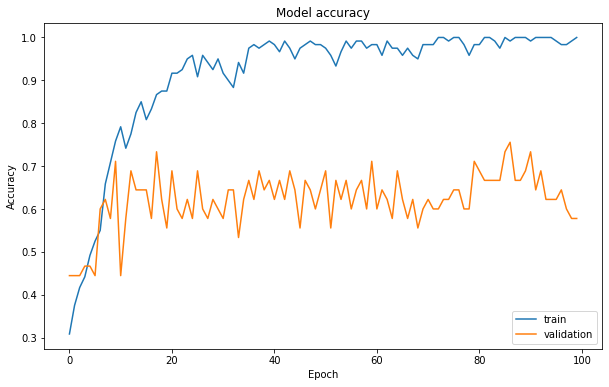

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

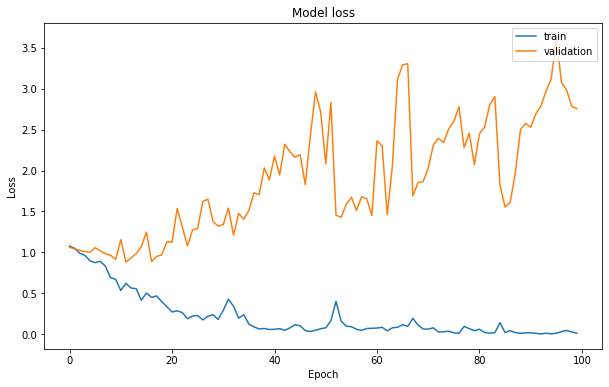

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### saving

In [ ]:

from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/My Drive/googledrive_segmentation/weight_cnn_CovidCtNet2d_unet.h5")